#**Regression**

#Import Librairies

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Load Data

### Prix du 03 mars au 02 mai 2025, Trajet Paris<=>Dubai

In [57]:
data = pd.read_csv('/content/sample_data/artifacts_flights_cleaned.csv')

data.head()

,id,out_duration,return_duration,out_time,return_time,out_stops,out_airline,price,scraped_time
0,1,6h 40min,7h 20min,10:00 – 19:40,14:40 – 20:00,direct,Emirates,952.0,2024-12-29 11:12:46
1,2,6h 40min,7h 20min,10:00 – 19:40,14:40 – 20:00,direct,Emirates,892.0,2024-12-29 11:12:46
2,3,6h 40min,7h 20min,23:20 – 09:00\n+1,00:40 – 06:00,direct,Air France,855.0,2024-12-29 11:12:46
3,13,6h 40min,7h 20min,10:00 – 19:40,14:40 – 20:00,direct,Emirates,952.0,2024-12-29 11:02:09
4,14,6h 40min,7h 20min,10:00 – 19:40,14:40 – 20:00,direct,Emirates,892.0,2024-12-29 11:02:09


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897 entries, 0 to 896
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               897 non-null    int64  
 1   out_duration     897 non-null    object 
 2   return_duration  897 non-null    object 
 3   out_time         897 non-null    object 
 4   return_time      897 non-null    object 
 5   out_stops        897 non-null    object 
 6   out_airline      897 non-null    object 
 7   price            897 non-null    float64
 8   scraped_time     897 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 63.2+ KB


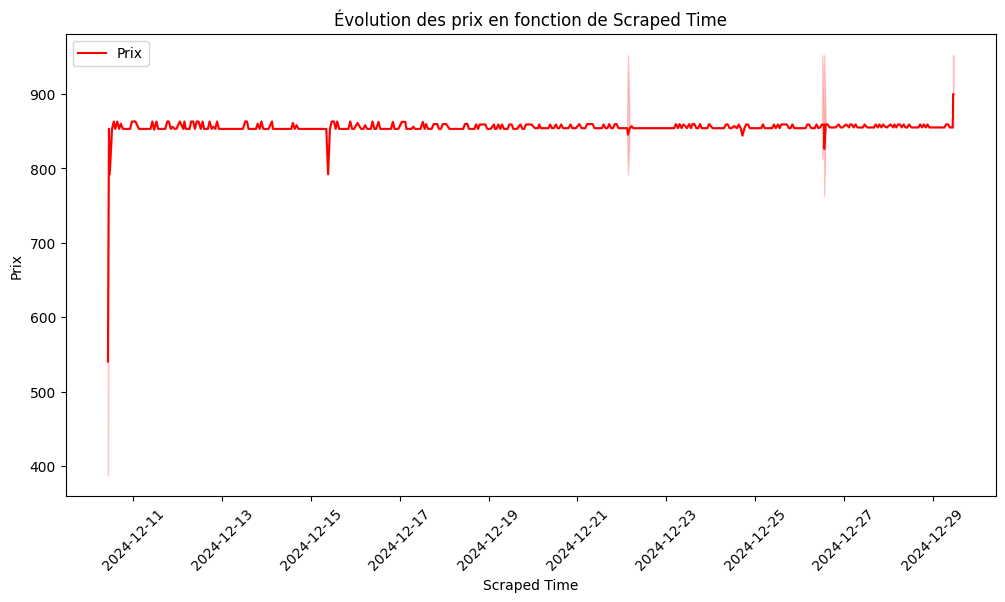

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# 'scraped_time' format datetime
data['scraped_time'] = pd.to_datetime(data['scraped_time'])

# Tracer les prix en fonction de scraped_time pour un voyage du 03 mars au 02 mai Paris<=>Dubai
plt.figure(figsize=(12, 6))
sns.lineplot(x=data['scraped_time'], y=data['price'], color='red', label='Prix')
plt.title('Évolution des prix en fonction de Scraped Time')
plt.xlabel('Scraped Time')
plt.ylabel('Prix')
plt.xticks(rotation=45)
plt.legend()
plt.show()


### Analyse brève de l'évolution des prix en fonction de `scraped_time` :

1. **Stabilité générale :**  
   - La majorité des prix restent constants autour d'une valeur stable (environ 850) pendant la période observée.

2. **Anomalies visibles :**  
   - Quelques baisses significatives sont observées à certaines dates (chutes ponctuelles vers des valeurs inférieures à 600). Ces baisses peuvent indiquer des promotions ou des anomalies dans la collecte des données.

Cette stabilité indique un marché relativement fixe, mais les anomalies doivent être explorées pour comprendre les baisses ou augmentations soudaines.

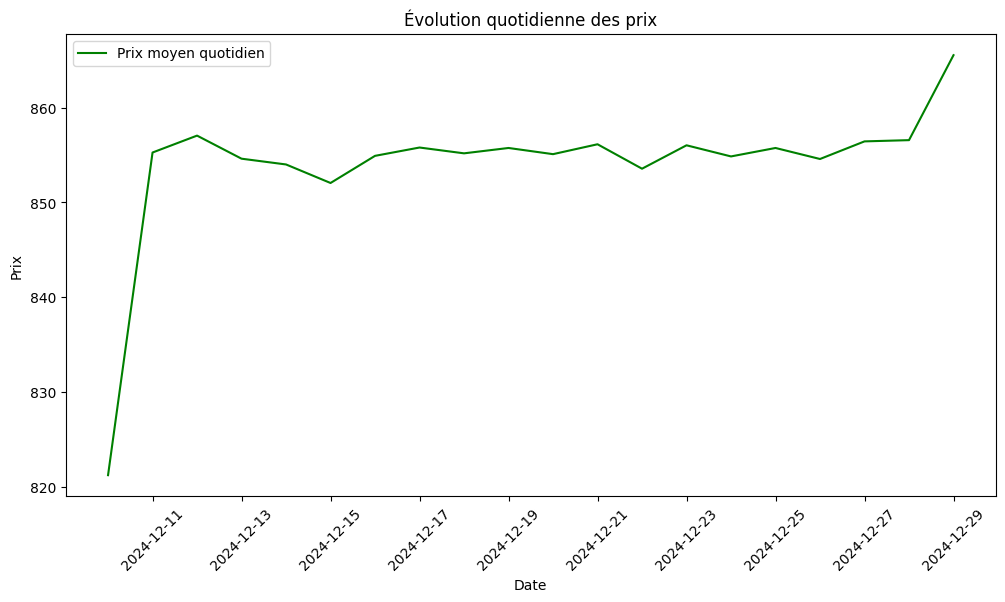

In [60]:
# Grouper par jour et calculer la moyenne
data_daily = data.groupby(data['scraped_time'].dt.date)['price'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=data_daily['scraped_time'], y=data_daily['price'], color='green', label='Prix moyen quotidien')
plt.title("Évolution quotidienne des prix")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.xticks(rotation=45)
plt.legend()
plt.show()


### Analyse brève de l'évolution quotidienne des prix :

1. **Tendance générale :**  
   - Les prix montrent une stabilité relative entre **850 et 860** après une augmentation initiale.

2. **Augmentation initiale :**  
   - Une forte augmentation est observée au début (12 décembre), suggérant une transition rapide à une plage de prix stable.

3. **Fluctuations mineures :**  
   - De petites variations (hausses et baisses) sont visibles sur la majorité de la période, indiquant un marché relativement constant.

4. **Pic en fin de période :**  
   - Une augmentation significative est observée à la fin (29 décembre), potentiellement due à une demande accrue en raison d'un événement ou de la fin de l'année.

In [61]:
data['out_stops'].unique()

array(['direct', '1 escale'], dtype=object)

In [62]:
data.shape

(897, 9)

In [63]:
# Conversion des durées de vol en minutes
def convert_duration(duration):
    try:
        hours, minutes = map(int, duration.lower().replace('h', '').replace('min', '').split())
        return hours * 60 + minutes
    except:
        return np.nan

data['out_duration'] = data['out_duration'].apply(convert_duration)
data['return_duration'] = data['return_duration'].apply(convert_duration)

In [64]:
data['out_duration'][0]

400

In [65]:
# Encodage des variables catégoriques
le = LabelEncoder()
data['out_airline'] = le.fit_transform(data['out_airline'])
data['out_stops'] = data['out_stops'].map({'direct': 0, '1 escale': 1})

In [66]:
data = data.drop(columns=['id', 'out_time', 'return_time', 'scraped_time'])
print(data.dtypes)

out_duration         int64
return_duration      int64
out_stops            int64
out_airline          int64
price              float64
dtype: object


In [67]:
#Split Data
X = data.drop(columns=['price'])
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# Normalisation des données
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [69]:
X_train_normalized_df = pd.DataFrame(X_train, columns=X.columns)
print(X_train_normalized_df.head())

     out_duration  return_duration  out_stops  out_airline
870           405              440          0            0
740           405              440          0            0
231           400              440          0            0
388           400              440          0            0
118           405              440          0            0


#Fine Tuning
- Find Best Hyperparameters for our model

In [70]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best hyperparameters :", grid_search.best_params_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best hyperparameters : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [71]:
# Réentraîner le modèle avec les meilleurs paramètres
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

#Prédictions + Evaluations
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}, )MSE: {mse}, R2: {r2}")


MAE: 4.001466789499874, )MSE: 147.87976007578203, R2: -0.5592815544751693


## Visualisations des performances

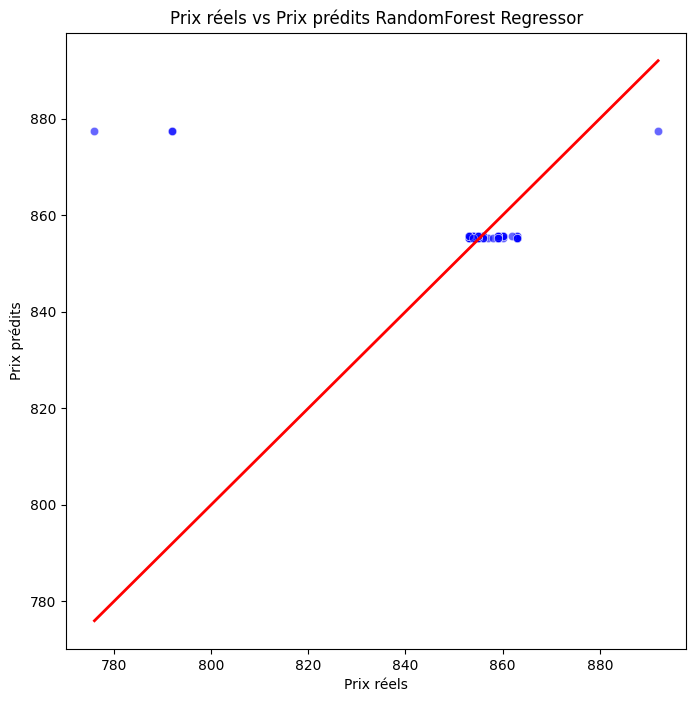

In [72]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.title('Prix réels vs Prix prédits RandomForest Regressor')
plt.xlabel('Prix réels')
plt.ylabel('Prix prédits')
plt.show()


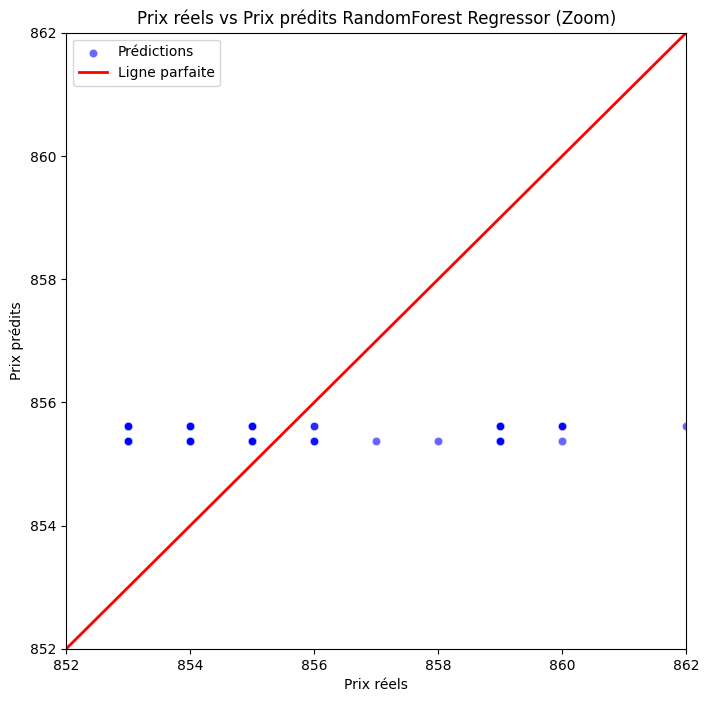

In [73]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue', label='Prédictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Ligne parfaite')
plt.title('Prix réels vs Prix prédits RandomForest Regressor (Zoom)')
plt.xlabel('Prix réels')
plt.ylabel('Prix prédits')

# Définir les limites des axes pour zoomer
plt.xlim(852, 862)  # Plage des prix réels
plt.ylim(852, 862)  # Plage des prix prédits

plt.legend()
plt.show()


### Analyse brève du graphique "Prix réels vs Prix prédits" pour RandomForestRegressor :


1. **Concentration des points :**
   - Les prédictions sont concentrées dans une plage étroite autour de **854 à 856**, quel que soit le prix réel.
   - Cela montre un biais du modèle à produire des prédictions proches d'une valeur moyenne, ce qui est un signe de '**underfitting**.

2. **Éloignement de la ligne parfaite :**
   - La plupart des points s'écartent significativement de la ligne rouge (ligne parfaite), surtout pour les prix réels plus faibles ou plus élevés.
   - Cela indique que le modèle ne capture pas bien la relation entre les variables explicatives et le prix.



In [44]:
print(f"Taille de y_test : {len(y_test)}")
print(f"Taille de y_pred : {len(y_pred)}")


Taille de y_test : 180
Taille de y_pred : 180


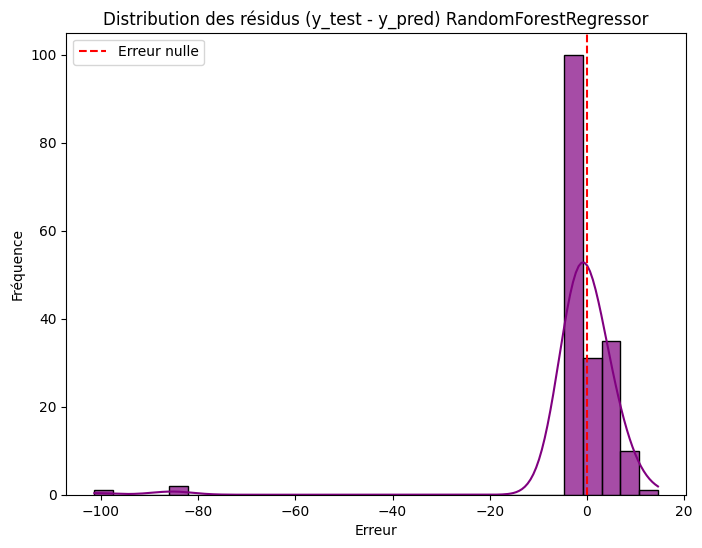

In [45]:
#KDE plot
errors = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(errors, kde=True, bins=30, color='purple', alpha=0.7)
plt.title('Distribution des résidus (y_test - y_pred) RandomForestRegressor')
plt.xlabel('Erreur')
plt.ylabel('Fréquence')
plt.axvline(0, color='red', linestyle='--', label='Erreur nulle')
plt.legend()
plt.show()


### Analyse brève de la distribution des résidus pour RandomForestRegressor :

1. **Concentration autour de zéro :**
   - La majorité des résidus (erreurs entre les valeurs réelles et prédites) sont proches de 0, ce qui indique une bonne performance du modèle pour la plupart des données.

2. **Asymétrie et queue longue :**
   - Une queue à gauche montre quelques erreurs significatives négatives, où le modèle a largement sous-estimé les prix réels.
   - Cela peut indiquer la présence d'outliers ou de cas difficiles pour le modèle.



### Outliers

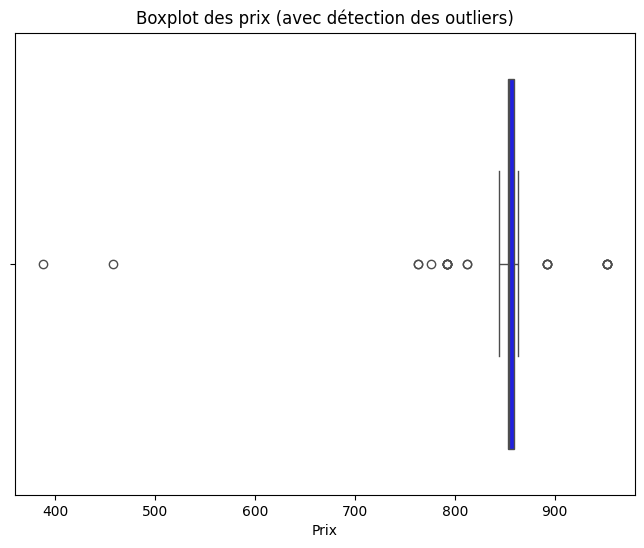

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x=data['price'], color='blue')
plt.title('Boxplot des prix (avec détection des outliers)')
plt.xlabel('Prix')
plt.show()


Les prix sont majoritairement concentrés dans une plage stable (autour de 850)

In [47]:
# Calcul des bornes pour détecter les outliers
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifier les outliers
outliers = data[(data['price'] < lower_bound) | (data['price'] > upper_bound)]
print(f"Nombre d'outliers : {len(outliers)}")


Nombre d'outliers : 22


=> underfitting

In [48]:
from xgboost import XGBRegressor

file_path = '/content/sample_data/artifacts_flights_cleaned.csv'
data = pd.read_csv(file_path)

print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897 entries, 0 to 896
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               897 non-null    int64  
 1   out_duration     897 non-null    object 
 2   return_duration  897 non-null    object 
 3   out_time         897 non-null    object 
 4   return_time      897 non-null    object 
 5   out_stops        897 non-null    object 
 6   out_airline      897 non-null    object 
 7   price            897 non-null    float64
 8   scraped_time     897 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 63.2+ KB
None


In [49]:
data['out_duration'] = data['out_duration'].apply(convert_duration)
data['return_duration'] = data['return_duration'].apply(convert_duration)

# Création d'une nouvelle caractéristique : durée totale
data['total_duration'] = data['out_duration'] + data['return_duration']

# Extraction des informations temporelles
data['scraped_time'] = pd.to_datetime(data['scraped_time'])
data['month'] = data['scraped_time'].dt.month
data['day_of_week'] = data['scraped_time'].dt.dayofweek

# Encodage des variables catégoriques
le = LabelEncoder()
data['out_airline'] = le.fit_transform(data['out_airline'])
data['out_stops'] = data['out_stops'].map({'direct': 0, '1 stop': 1, '2 stops': 2})

# Suppression des colonnes inutiles
data.drop(columns=['id', 'out_time', 'return_time', 'scraped_time'], inplace=True)

# Suppression des valeurs aberrantes dans 'price'
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)]

data.head()


,out_duration,return_duration,out_stops,out_airline,price,total_duration,month,day_of_week
2,400,440,0.0,0,855.0,840,12,6
5,400,440,0.0,0,855.0,840,12,6
6,405,440,0.0,0,855.0,845,12,6
8,400,440,0.0,0,855.0,840,12,6
9,405,440,0.0,0,855.0,845,12,6


In [50]:
# Division des données en ensembles d'entraînement et de test
X = data.drop(columns=['price'])
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modèle avancé : XGBoost avec recherche d'hyperparamètres
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

search = RandomizedSearchCV(
    XGBRegressor(random_state=42, use_label_encoder=False),
    param_distributions=param_grid,
    n_iter=50,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

search.fit(X_train, y_train)

# Meilleur modèle
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

# Évaluation du modèle
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Performance du modèle XGBoost :")
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"R² : {r2}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Performance du modèle XGBoost :
MAE : 2.6084671456473214
MSE : 9.91286835340517
R² : 0.004010467962909825


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:03:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


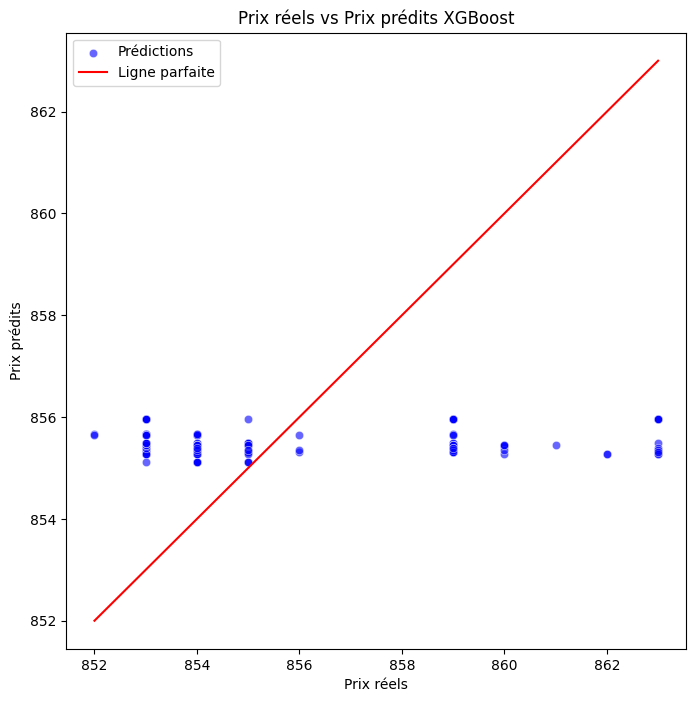

In [51]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue', label='Prédictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ligne parfaite')
plt.title('Prix réels vs Prix prédits XGBoost')
plt.xlabel('Prix réels')
plt.ylabel('Prix prédits')
plt.legend()
plt.show()

### Analyse brève du graphique "Prix réels vs Prix prédits" pour XGBoost :

1. **Concentration des points :**
   - Les prédictions sont concentrées dans une plage étroite autour de **854 à 856**, quel que soit le prix réel.
   - Cela montre un biais du modèle à produire des prédictions proches d'une valeur moyenne, ce qui est un signe de '**underfitting**.

2. **Éloignement de la ligne parfaite :**
   - La plupart des points s'écartent significativement de la ligne rouge (ligne parfaite), surtout pour les prix réels plus faibles ou plus élevés.
   - Cela indique que le modèle ne capture pas bien la relation entre les variables explicatives et le prix.


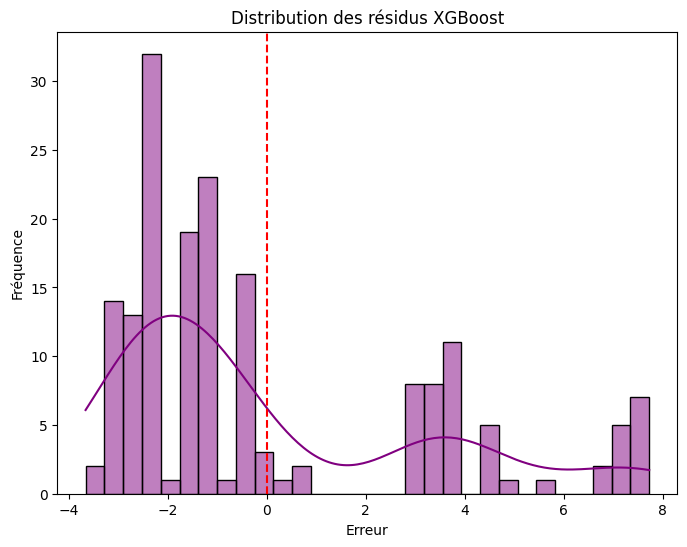

In [52]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title('Distribution des résidus XGBoost')
plt.xlabel('Erreur')
plt.ylabel('Fréquence')
plt.axvline(0, color='red', linestyle='--')
plt.show()

### Analyse brève de la distribution des résidus pour XGBoost :

1. **Concentration autour de zéro :**
   - Une grande partie des résidus est concentrée autour de **0**, ce qui est attendu pour un modèle qui minimise les erreurs.
   - Cela indique que le modèle a globalement des prédictions proches des valeurs réelles.

2. **Asymétrie dans les erreurs :**
   - Il y a une asymétrie marquée, avec plus de résidus négatifs (sous-estimation) que positifs (sur-estimation).
   - Cela peut indiquer un biais systématique dans les prédictions, où le modèle tend à sous-estimer les prix réels.



#Comparaison des modèles

<ipython-input-53-3dcfd1253ae1>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Modèle', y='MAE', palette='Blues_d')
<ipython-input-53-3dcfd1253ae1>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Modèle', y='MSE', palette='Oranges_d')


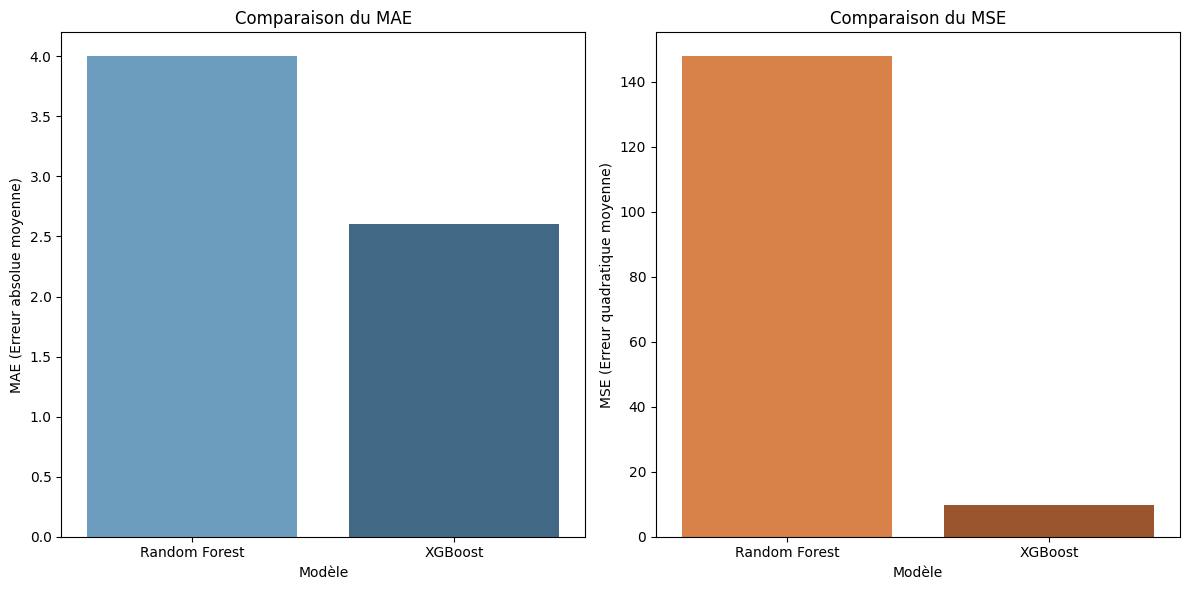

<ipython-input-53-3dcfd1253ae1>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Modèle', y='R²', palette='Greens_d')


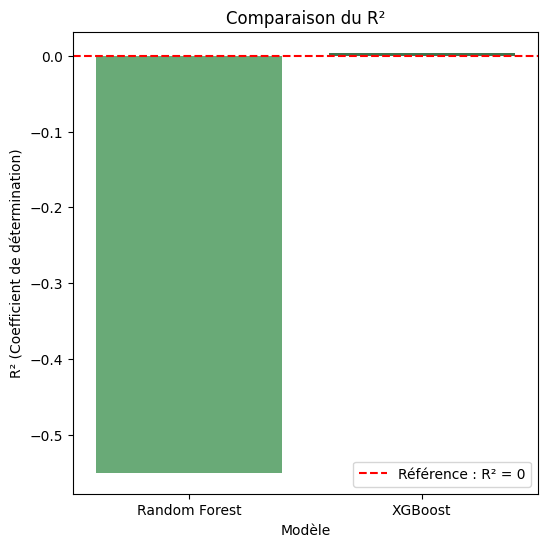

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results = {
    'Modèle': ['Random Forest', 'XGBoost'],
    'MAE': [4.0, 2.6],
    'MSE': [147.8, 9.91],
    'R²': [-0.55, 0.004]
}

results_df = pd.DataFrame(results)

# Visualisation des métriques : MAE et MSE
plt.figure(figsize=(12, 6))

# Sous-graphe pour MAE
plt.subplot(1, 2, 1)
sns.barplot(data=results_df, x='Modèle', y='MAE', palette='Blues_d')
plt.title('Comparaison du MAE')
plt.ylabel('MAE (Erreur absolue moyenne)')
plt.xlabel('Modèle')

# Sous-graphe pour MSE
plt.subplot(1, 2, 2)
sns.barplot(data=results_df, x='Modèle', y='MSE', palette='Oranges_d')
plt.title('Comparaison du MSE')
plt.ylabel('MSE (Erreur quadratique moyenne)')
plt.xlabel('Modèle')

plt.tight_layout()
plt.show()

# Visualisation pour R²
plt.figure(figsize=(6, 6))
sns.barplot(data=results_df, x='Modèle', y='R²', palette='Greens_d')
plt.title('Comparaison du R²')
plt.ylabel('R² (Coefficient de détermination)')
plt.xlabel('Modèle')
plt.axhline(0, color='red', linestyle='--', label='Référence : R² = 0')
plt.legend()
plt.show()


### **Conclusion globale**
- Le **modèle XGBoost** est **meilleur** pour ce problème, offrant des erreurs (MAE et MSE) beaucoup plus faibles et un R² légèrement positif.
- En revanche, le **modèle Random Forest** présente un mauvais ajustement aux données, ce qui pourrait nécessiter des ajustements tels qu'une augmentation du nombre d'estimations, une meilleure sélection de caractéristiques ou un prétraitement plus efficace des données.

### **Conclusion sur la Variabilité des Prix des Billets d'Avion**

Les résultats obtenus, notamment la faible variabilité des prédictions, peuvent s'expliquer par la relative stabilité des prix des billets d'avion sur certaines périodes. Les compagnies aériennes utilisent des stratégies de tarification sophistiquées, comme le **yield management**, pour optimiser le remplissage de leurs vols et maximiser leurs revenus.

https://www.air-journal.fr/2024-07-30-info-pratique-yield-management-ou-comment-est-fixe-le-prix-du-billet-davion-5253944.html

Cette approche implique une variation des prix en fonction de la demande, de la période de réservation et d'autres facteurs. Cependant, sur des périodes spécifiques, les prix peuvent rester relativement constants, surtout lorsque les compagnies ont atteint leurs objectifs de remplissage ou en l'absence de fluctuations significatives de la demande.

Ainsi, la faible variabilité des prix observée dans les prédictions peut être le reflet de ces pratiques tarifaires, où les compagnies maintiennent des prix stables sur certaines périodes pour optimiser le remplissage de leurs vols et maximiser leurs revenus.


https://www.lemonde.fr/economie/article/2024/10/13/le-secteur-aerien-pionnier-de-la-fluctuation-des-prix_6351068_3234.html

